In [1]:
import ta
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import tensorflow as tf
from Transformer_model import TransformerModel

In [2]:

df = pd.read_csv('./NQ_5Years_8_11_2024.csv', header=0, index_col=0)
df.index = pd.to_datetime(df.index).tz_localize(None).to_period('T')
df.rename(columns={'Close':'close','Volume':'volume'},inplace=True)
df = df[-10000:]
print(df.shape)

(10000, 5)


/var/folders/6r/z18bl2nj0nx5tvwj_2g191gh0000gn/T/ipykernel_34045/2640827210.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df.index = pd.to_datetime(df.index).tz_localize(None).to_period('T')


In [3]:
df['label'] = df.close.shift(-1) - df.close
# df.label = df.label.apply(lambda x: 0 if x < 0 else 1)
df.head()

,Open,High,Low,close,volume,label
Time,,,,,,
2024-06-20 03:55,20334.75,20345.00,20334.75,20337.25,585,3.00
2024-06-20 04:00,20337.00,20341.25,20331.50,20340.25,801,-13.75
2024-06-20 04:05,20339.75,20340.50,20323.50,20326.50,1476,7.00
2024-06-20 04:10,20327.00,20338.75,20326.25,20333.50,879,-3.50
2024-06-20 04:15,20333.50,20337.75,20320.50,20330.00,817,-3.75


In [4]:
# Momentum indicators
df['roc'] = ta.momentum.roc(close=df.close) # Rate of Change (ROC)
df['rsi'] = ta.momentum.rsi(close=df.close) # Relative Strength Index (RSI)
df['tsi'] = ta.momentum.tsi(close=df.close) # True strength index (TSI)

# Volatility indicators
bb_indicator = ta.volatility.BollingerBands(close=df.close)
df['bb_bbhi'] = bb_indicator.bollinger_hband_indicator() # Bollinger Band high indicator
df['bb_bbli'] = bb_indicator.bollinger_lband_indicator() # Bollinger Band low indicator

# Trend indicators
aroon_indicator = ta.trend.AroonIndicator(high=df.High, low=df.Low, window=14)
macd_indicator = ta.trend.MACD(close=df.close)
kst_indicator = ta.trend.KSTIndicator(close=df.close)
df['aroon_down'] = aroon_indicator.aroon_down() # Aroon Down Channel
df['aroon'] = aroon_indicator.aroon_indicator() # Aroon Indicator
df['aroon_up'] = aroon_indicator.aroon_up() # Aroon Up Channel
df['macd_line'] = macd_indicator.macd() # MACD Line
df['macd_hist'] = macd_indicator.macd_diff() # MACD Histogram
df['macd_signal'] = macd_indicator.macd_signal() # MACD Signal Line
df['kst'] = kst_indicator.kst() # Know Sure Thing (KST)
df['kst_diff'] = kst_indicator.kst_diff() # Diff Know Sure Thing (KST)
df['kst_signal'] = kst_indicator.kst_sig() # Signal Line Know Sure Thing (KST)
df['dpo'] = ta.trend.dpo(close=df.close) # Detrended Price Oscillator (DPO)
df['trix'] = ta.trend.trix(close=df.close) # Trix (TRIX)
df['sma_10'] = ta.trend.sma_indicator(close=df.close, window=10) # SMA n=10
df['sma_20'] = ta.trend.sma_indicator(close=df.close, window=20) # SMA n=20
df['sma_30'] = ta.trend.sma_indicator(close=df.close, window=30) # SMA n=30
df['sma_60'] = ta.trend.sma_indicator(close=df.close, window=60) # SMA n=60
df['ema_10'] = ta.trend.sma_indicator(close=df.close, window=10) # EMA n=10
df['ema_20'] = ta.trend.sma_indicator(close=df.close, window=20) # EMA n=20
df['ema_30'] = ta.trend.sma_indicator(close=df.close, window=30) # EMA n=30
df['ema_60'] = ta.trend.sma_indicator(close=df.close, window=60) # EMA n=60

# Volume indicators
df['obv'] = ta.volume.on_balance_volume(close=df.close, volume=df.volume) # On Balance Volume (OBV)
df['vpt'] = ta.volume.volume_price_trend(close=df.close, volume=df.volume) # Volume-price trend (VPT)
df['fi'] = ta.volume.force_index(close=df.close, volume=df.volume) # Force Index (FI)
df['nvi'] = ta.volume.negative_volume_index(close=df.close, volume=df.volume) # Negative Volume Index (NVI)

df.tail()

,Open,High,Low,close,volume,label,roc,rsi,tsi,bb_bbhi,...,sma_30,sma_60,ema_10,ema_20,ema_30,ema_60,obv,vpt,fi,nvi
Time,,,,,,,,,,,,,,,,,,,,,
2024-08-09 16:35,18604.50,18608.50,18602.75,18604.00,287,0.50,-0.051038,50.683810,5.868646,0.0,...,18601.783333,18574.845833,18609.60,18606.4875,18601.783333,18574.845833,-443364,-1877.577112,4891.754732,1176.972618
2024-08-09 16:40,18604.00,18606.50,18603.00,18604.50,187,-3.75,-0.010749,50.863084,5.334078,0.0,...,18601.141667,18576.454167,18608.15,18606.9625,18601.141667,18576.454167,-443177,-1877.572086,4206.289770,1177.004251
2024-08-09 16:45,18604.50,18604.75,18599.75,18600.75,331,-2.50,-0.026873,49.412279,4.511411,0.0,...,18601.541667,18577.895833,18609.30,18608.2125,18601.541667,18577.895833,-443508,-1877.638804,3428.069803,1177.004251
2024-08-09 16:50,18601.25,18601.75,18597.50,18598.25,398,-1.50,-0.111445,48.420691,3.554736,0.0,...,18601.600000,18579.037500,18608.15,18608.1000,18601.600000,18579.037500,-443906,-1877.692297,2796.202688,1177.004251
2024-08-09 16:55,18598.00,18600.00,18595.75,18596.75,313,NaN,0.040346,47.800868,2.575215,0.0,...,18602.300000,18580.087500,18606.00,18607.5250,18602.300000,18580.087500,-444219,-1877.717541,2329.673733,1176.909322


In [5]:

df['datetime'] = df.index.to_timestamp()
df['min_sin'] = np.sin(2 * np.pi * df.datetime.dt.minute / 60)
df['min_cos'] = np.cos(2 * np.pi * df.datetime.dt.minute / 60)
df['hour_sin'] = np.sin(2 * np.pi * df.datetime.dt.hour / 60)
df['hour_cos'] = np.cos(2 * np.pi * df.datetime.dt.hour / 60)
df['day_sin'] = np.sin(2 * np.pi * df.datetime.dt.day / 30)
df['day_cos'] = np.cos(2 * np.pi * df.datetime.dt.day / 30)
df['month_sin'] = np.sin(2 * np.pi * df.datetime.dt.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df.datetime.dt.month / 12)

df = df.drop(['datetime'], axis=1)
print(df.shape)
df.tail()

(10000, 42)


,Open,High,Low,close,volume,label,roc,rsi,tsi,bb_bbhi,...,fi,nvi,min_sin,min_cos,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
Time,,,,,,,,,,,,,,,,,,,,,
2024-08-09 16:35,18604.50,18608.50,18602.75,18604.00,287,0.50,-0.051038,50.683810,5.868646,0.0,...,4891.754732,1176.972618,-0.500000,-8.660254e-01,0.994522,-0.104528,0.951057,-0.309017,-0.866025,-0.5
2024-08-09 16:40,18604.00,18606.50,18603.00,18604.50,187,-3.75,-0.010749,50.863084,5.334078,0.0,...,4206.289770,1177.004251,-0.866025,-5.000000e-01,0.994522,-0.104528,0.951057,-0.309017,-0.866025,-0.5
2024-08-09 16:45,18604.50,18604.75,18599.75,18600.75,331,-2.50,-0.026873,49.412279,4.511411,0.0,...,3428.069803,1177.004251,-1.000000,-1.836970e-16,0.994522,-0.104528,0.951057,-0.309017,-0.866025,-0.5
2024-08-09 16:50,18601.25,18601.75,18597.50,18598.25,398,-1.50,-0.111445,48.420691,3.554736,0.0,...,2796.202688,1177.004251,-0.866025,5.000000e-01,0.994522,-0.104528,0.951057,-0.309017,-0.866025,-0.5
2024-08-09 16:55,18598.00,18600.00,18595.75,18596.75,313,NaN,0.040346,47.800868,2.575215,0.0,...,2329.673733,1176.909322,-0.500000,8.660254e-01,0.994522,-0.104528,0.951057,-0.309017,-0.866025,-0.5


In [6]:

df_na = df.dropna(axis=0)
print(df_na.shape)
df_na.head()

(9940, 42)


,Open,High,Low,close,volume,label,roc,rsi,tsi,bb_bbhi,...,fi,nvi,min_sin,min_cos,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
Time,,,,,,,,,,,,,,,,,,,,,
2024-06-20 08:50,20269.75,20275.00,20262.50,20273.00,1734,7.25,-0.162514,33.468576,-29.808435,0.0,...,-9312.096353,999.999790,-0.866025,0.500000,0.743145,0.669131,-0.866025,-0.5,1.224647e-16,-1.0
2024-06-20 08:55,20272.50,20282.75,20270.00,20280.25,2036,-12.75,-0.086216,39.012952,-28.425308,0.0,...,-5873.082588,999.999790,-0.500000,0.866025,0.743145,0.669131,-0.866025,-0.5,1.224647e-16,-1.0
2024-06-20 09:00,20280.25,20280.50,20262.25,20267.50,2313,-0.75,-0.144112,33.694960,-29.114709,0.0,...,-9247.035075,999.999790,0.000000,1.000000,0.809017,0.587785,-0.866025,-0.5,1.224647e-16,-1.0
2024-06-20 09:05,20268.00,20270.75,20262.25,20266.75,1703,-6.00,-0.184690,33.406487,-29.735605,0.0,...,-8108.494350,999.962785,0.500000,0.866025,0.809017,0.587785,-0.866025,-0.5,1.224647e-16,-1.0
2024-06-20 09:10,20267.00,20270.00,20253.50,20260.75,2277,-3.00,-0.156462,31.111717,-30.992820,0.0,...,-8901.852300,999.962785,0.866025,0.500000,0.809017,0.587785,-0.866025,-0.5,1.224647e-16,-1.0


In [7]:
df_na.columns


Index(['Open', 'High', 'Low', 'close', 'volume', 'label', 'roc', 'rsi', 'tsi',
       'bb_bbhi', 'bb_bbli', 'aroon_down', 'aroon', 'aroon_up', 'macd_line',
       'macd_hist', 'macd_signal', 'kst', 'kst_diff', 'kst_signal', 'dpo',
       'trix', 'sma_10', 'sma_20', 'sma_30', 'sma_60', 'ema_10', 'ema_20',
       'ema_30', 'ema_60', 'obv', 'vpt', 'fi', 'nvi', 'min_sin', 'min_cos',
       'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos'],
      dtype='object')

In [8]:

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 创建 ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), slice(0, 11)),  # 特征 0-10 使用 Min-Max Scaling
        ('standard', StandardScaler(), slice(11, 42))  # 特征 11-40 使用 StandardScaler
    ]
)

x_values = df_na.values

# 拟合和转换数据
x_values = preprocessor.fit_transform(x_values)


y_values = x_values[:,0]

X_train, X_test, y_train, y_test = train_test_split(x_values, y_values, test_size=0.05, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9443, 42), (497, 42), (9443,), (497,))

In [9]:

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

TIMESTEP = 64
# 定义自注意力层
class SelfAttentionLayer(layers.Layer):
    def __init__(self):
        super(SelfAttentionLayer, self).__init__()

    def build(self, input_shape):
        self.features = input_shape[-1]
        self.Wq = self.add_weight(shape=(self.features, self.features), initializer='random_normal', trainable=True)
        self.Wk = self.add_weight(shape=(self.features, self.features), initializer='random_normal', trainable=True)
        self.Wv = self.add_weight(shape=(self.features, self.features), initializer='random_normal', trainable=True)

    def call(self, inputs):
        Q = tf.matmul(inputs, self.Wq)
        K = tf.matmul(inputs, self.Wk)
        V = tf.matmul(inputs, self.Wv)

        score = tf.matmul(Q, K, transpose_b=True)
        weights = tf.nn.softmax(score, axis=-1)
        context = tf.matmul(weights, V)
        return context

# 定义 LSTM 模型
def create_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    dense_out = layers.Dense(128, activation='relu')(inputs)
    dense_out = layers.Dense(256, activation='relu')(dense_out)
    lstm_out = layers.LSTM(256, return_sequences=True)(dense_out)
    attention_out = SelfAttentionLayer()(lstm_out)
    lstm_out = layers.LSTM(256)(attention_out)
    
    # 添加全连接层
    dense_out = layers.Dense(64, activation='relu')(lstm_out)
    dense_out = layers.Dense(32, activation='relu')(dense_out)
    outputs = layers.Dense(1)(dense_out)  # 最后的输出层

    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# 创建模型
input_shape = (TIMESTEP, 42)  # 时间步和特征数
model = create_model(input_shape)



In [ ]:
import numpy as np

def create_time_series_data(X, time_steps):
    X_t = []
    for i in range(len(X) - time_steps):
        X_t.append(X[i:i + time_steps])  # 时间步数据
        
    return np.array(X_t)

X_train = create_time_series_data(X_train , TIMESTEP)

y_train = y_train[TIMESTEP:]
print(f"X shape: {X_train.shape}")  
print(f"y shape: {y_train.shape}")  

In [16]:
print(X_train[1][0])
print(y_train[0])

[ 0.53013747  0.5255814   0.54412584  0.53489356  0.10492057  0.50872657
  0.68736307  0.67003007  0.63838713  0.          0.         -1.04806039
  1.05946425  0.78683361  0.98297038  2.52983363  0.28338326  0.28092028
  3.4371741  -0.7601553  -3.28446655  0.12566915 -0.55263977 -0.63195042
 -0.61905586 -0.58336809 -0.55263977 -0.63195042 -0.61905586 -0.58336809
 -0.68487414 -0.92262115  0.7311398   0.99504653 -1.2248659  -0.70742567
  0.86586532  0.02453475 -0.30190076  1.21504229 -0.08815643 -0.26967791]
0.8398308071906939


In [ ]:

# 训练模型
model.fit(X_train[:500], y_train[:500], epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - loss: 0.0810 - val_loss: 0.0473
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - loss: 0.0480 - val_loss: 0.0474
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 171ms/step - loss: 0.0468 - val_loss: 0.0504
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - loss: 0.0479 - val_loss: 0.0507
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - loss: 0.0458 - val_loss: 0.0473
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - loss: 0.0452 - val_loss: 0.0477
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - loss: 0.0461 - val_loss: 0.0473
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 178ms/step - loss: 0.0466 - val_loss: 0.0473
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 171ms/step - loss: 0.0472 - val_loss: 0.0503
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - loss: 0.0470 - val_loss: 0.0474


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step


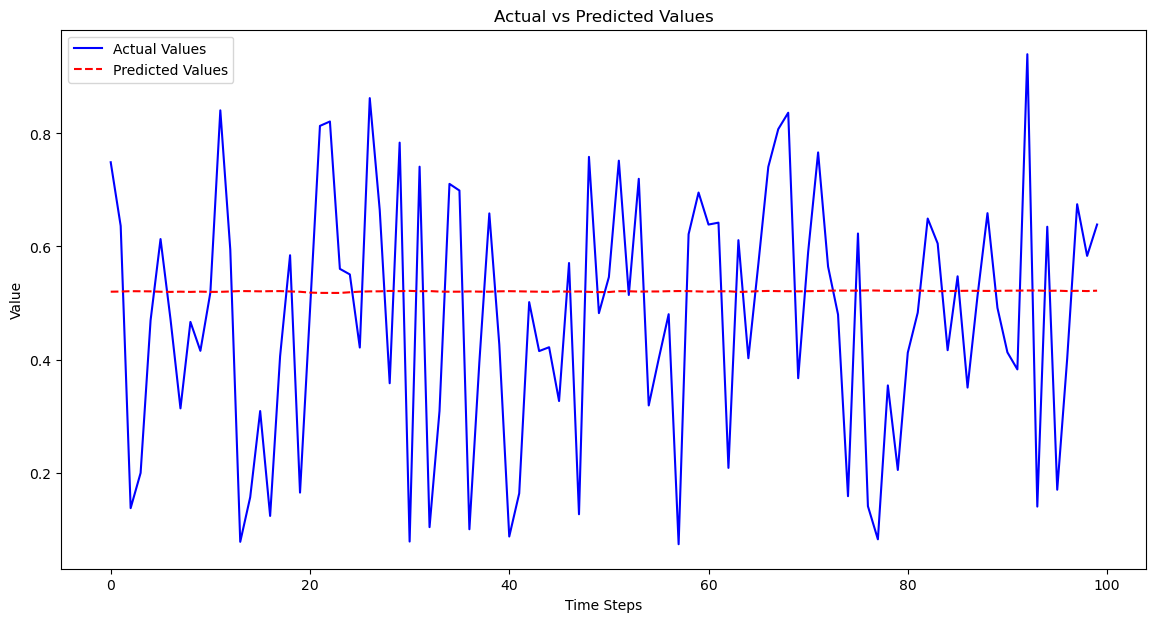

In [12]:
# Make predictions
X_test = create_time_series_data(X_test, TIMESTEP)
y_pred = model.predict(X_test[:100])

# Plotting function
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(14, 7))
    plt.plot(y_true, label='Actual Values', color='b')
    plt.plot(y_pred, label='Predicted Values', color='r', linestyle='--')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Call the plotting function
plot_predictions(y_test[:100], y_pred[:100])